In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfresh.feature_extraction.feature_calculators as tsf

In [13]:
ogTrainData = pd.read_csv('train.csv')
ogTestData = pd.read_csv('test.csv')

trainData = ogTrainData.copy()
ogTestData.isna().sum()

ID                              0
measurement_time                0
source_1_temperature            0
source_2_temperature            0
source_3_temperature            0
source_4_temperature            0
mean_room_temperature           0
sun_radiation_east              0
sun_radiation_west              0
sun_radiation_south             0
sun_radiation_north             0
sun_radiation_perpendicular     0
outside_temperature            13
wind_speed                     13
wind_direction                 13
clouds                         13
dtype: int64

In [14]:
def edit_data(df):
    df.rename(columns={
    "source_1_temperature" : "heater-1",
    "source_2_temperature" : "hvac-1",
    "source_3_temperature" : "hvac-2",
    "source_4_temperature" : "heater-2",
    }, inplace=True)
    
    df["measurement_time"] = pd.to_datetime(df.measurement_time)
    df.insert(1, "time", df.measurement_time.dt.hour)
    df["day_of_week"] = df.measurement_time.dt.dayofweek
    df["is_weekend"] = df.day_of_week >= 5
    df["month"] = df.measurement_time.dt.month
    
    df["total_consumption"] = df[["heater-1", "heater-2", "hvac-1", "hvac-2"]].sum(axis=1)
    df["total_hvac_consumption"] = df[["hvac-1", "hvac-2"]].sum(axis=1)
    df["total_heater_consumption"] = df[["heater-1", "heater-2"]].sum(axis=1)
    
    df["temp_diff"] = df["outside_temperature"] - df["mean_room_temperature"]
    
    df["total_hvac_consump"] = df[["hvac-1", "hvac-2"]].sum(axis=1)
    
    radiation_cols = ["sun_radiation_east", "sun_radiation_west", "sun_radiation_south", "sun_radiation_north"]
    
    df["dominant_radiation"] = df[radiation_cols].max(axis=1)
    df["total_solar_radiation"] = df[radiation_cols].sum(axis=1)
    df["adjusted_radiation"] = df["total_solar_radiation"] * (1 - df["clouds"])
    
    df["wind_direction_radians"] = np.radians(df["wind_direction"])
    df["wind_y"] = df["wind_speed"] * np.sin(df["wind_direction_radians"])
    df["wind_x"] = df["wind_speed"] * np.cos(df["wind_direction_radians"])
    
    df["hvac_temp_interaction"] = df["total_hvac_consumption"] * df["mean_room_temperature"]
    df["heater_temp_interaction"] = df["total_heater_consumption"] * df["mean_room_temperature"]
    df["wind_temp_interaction"] = df["wind_speed"] * df["mean_room_temperature"]
    df["solar_temp_interaction"] = df["total_solar_radiation"] * df["mean_room_temperature"]
    df["hvac_heater_interaction"] = df["total_hvac_consumption"] * df["total_heater_consumption"]
    
    for feature in lag_features:
        df[f"{feature}_lag_1"] = df[feature].shift(1)

    
    return df



allFeatures = [
'hvac_heater_interaction',
'solar_temp_interaction',
'wind_temp_interaction',
'heater_temp_interaction',
'hvac_temp_interaction',
'time',
'heater-1',
'hvac-1',
'hvac-2',
'heater-2',
'mean_room_temperature',
'sun_radiation_east',
'sun_radiation_west',
'sun_radiation_south',
'sun_radiation_north',
'sun_radiation_perpendicular',
'outside_temperature',
'wind_speed',
'wind_direction',
'day_of_week',
'is_weekend',
'month',
'total_consumption',
'temp_diff',
'total_hvac_consump',
'dominant_radiation',
'total_solar_radiation',
'adjusted_radiation',
'wind_direction_radians',
'wind_y',
'wind_x',
]

test_features = [
    'temp_diff_lag_1', 'total_consumption_lag_1', 'heater-1_lag_1', 'hvac-1_lag_1', 'heater-2_lag_1', 'hvac-2_lag_1'
]



lag_features = ['total_consumption', 'temp_diff', 'heater-1', 'hvac-1', 'heater-2', 'hvac-2', 'mean_room_temperature', 'outside_temperature']

base_features = [
    'heater-1', 'hvac-1', 'heater-2', 'hvac-2',
    'sun_radiation_south', 'sun_radiation_north',
    'mean_room_temperature', 'sun_radiation_east', 'sun_radiation_west',
    'sun_radiation_perpendicular', 'outside_temperature', 'wind_speed',
    'wind_direction', 'clouds' 
    ]


# Time Features
time_features = [
    'time', 'day_of_week', 'is_weekend', 'month' 
]

# HVAC and Heater Features
hvac_heater_features = [
    'heater-1', 'hvac-1', 'hvac-2', 'heater-2', 'total_hvac_consump', "hvac_temp_interaction", "heater_temp_interaction"]


# Temperature Features
temperature_features = [
    'mean_room_temperature', 'outside_temperature', 'temp_diff' 
]

# Solar Radiation Features
solar_radiation_features = [
    'sun_radiation_east', 'sun_radiation_west', 'sun_radiation_south',
    'sun_radiation_north', 'sun_radiation_perpendicular',
    'total_solar_radiation', 'dominant_radiation', 'adjusted_radiation' 
]

# Wind Features
wind_features = [
    'wind_x', 'wind_y' 
]

# Consumption Features
consumption_features = [
    'total_consumption' 
]

feature_sets = {
    "time_features": time_features,
    "hvac_heater_features": hvac_heater_features,
    "temperature_features": temperature_features,
    "solar_radiation_features": solar_radiation_features,
    "wind_features": wind_features,
    "consumption_features": consumption_features,
    "test_features": test_features
}

features = list(set(test_features + base_features + time_features + hvac_heater_features + temperature_features + solar_radiation_features + wind_features + consumption_features))

trainData = edit_data(trainData)

#show all columns

allFeatures = list(set(allFeatures + test_features + base_features + time_features + hvac_heater_features + temperature_features + solar_radiation_features + wind_features + consumption_features))


features.remove('sun_radiation_south')
features.remove('sun_radiation_north')
features.remove('sun_radiation_east')
features.remove('sun_radiation_west')
features.remove('sun_radiation_perpendicular')
features.remove('clouds')
features.remove('wind_direction')
features.remove('day_of_week')
features.remove('month')
features.remove('total_hvac_consump')
features.remove('adjusted_radiation')
features.remove('wind_x')
features.remove("heater_temp_interaction")
features.remove("hvac_temp_interaction")
features.remove("dominant_radiation")

pd.set_option('display.max_columns', None)
print(allFeatures)
features = [
    "time",
    "heater-1",
    "heater-2",
    "hvac-2",
    "hvac-1",
    "mean_room_temperature",
    "outside_temperature",
    "total_consumption",
    "total_consumption_lag_1",
]
trainData[features]

['total_consumption', 'sun_radiation_north', 'adjusted_radiation', 'heater-2_lag_1', 'mean_room_temperature', 'is_weekend', 'hvac_temp_interaction', 'wind_x', 'wind_speed', 'temp_diff', 'sun_radiation_west', 'time', 'total_hvac_consump', 'hvac-1', 'hvac_heater_interaction', 'sun_radiation_perpendicular', 'total_consumption_lag_1', 'hvac-2_lag_1', 'heater-1', 'outside_temperature', 'clouds', 'hvac-1_lag_1', 'wind_y', 'wind_temp_interaction', 'solar_temp_interaction', 'wind_direction_radians', 'hvac-2', 'heater-2', 'dominant_radiation', 'total_solar_radiation', 'month', 'sun_radiation_south', 'day_of_week', 'temp_diff_lag_1', 'sun_radiation_east', 'heater-1_lag_1', 'wind_direction', 'heater_temp_interaction']


,time,heater-1,heater-2,hvac-2,hvac-1,mean_room_temperature,outside_temperature,total_consumption,total_consumption_lag_1
0,0,27.600000,21.100000,19.750000,18.799999,20.129892,8.97,87.250000,NaN
1,1,28.400000,21.033333,19.833333,18.933333,20.052919,9.19,88.199999,87.250000
2,2,29.400000,21.000000,19.799999,19.000000,19.992375,9.42,89.199999,88.199999
3,3,30.100000,24.600000,19.933333,19.033333,19.941565,9.19,93.666667,89.199999
4,4,31.866666,24.700000,20.000000,19.100000,19.924502,9.99,95.666667,93.666667
...,...,...,...,...,...,...,...,...,...
7042,10,19.150001,21.475000,16.275000,16.666667,21.276690,22.39,73.566668,73.191667
7043,11,26.750000,21.525000,16.100000,16.449999,21.392902,22.59,80.824999,73.566668
7044,12,38.666667,19.350000,16.075000,16.100000,21.567946,23.78,90.191667,80.824999
7045,13,39.875000,17.366667,16.033333,16.050000,21.517143,24.10,89.325000,90.191667


In [16]:
trainingDataX = trainData[features]
trainingDataY = trainData["target"]

print("X train shape:", trainingDataX.shape)
print("Y train shape:", trainingDataY.shape)

X train shape: (7047, 9)
Y train shape: (7047,)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


In [18]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def time_transformer(df):
    df["hour_sin"] = np.sin(df["time"] / 24 * 2 * np.pi)
    df["hour_cos"] = np.cos(df["time"] / 24 * 2 * np.pi)
    return df


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    trainingDataX, trainingDataY, test_size=0.3, random_state=42, shuffle=False
)

In [20]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=20, n_jobs=-1, min_samples_split=2)),
    ('xgb', XGBRegressor(learning_rate=0.01, n_estimators=50, n_jobs=-1)),
    ('knn', KNeighborsRegressor(n_neighbors=5, weights='distance'))
]

meta_model = LinearRegression()

stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

steps = [
    ('time_transformer', FunctionTransformer(time_transformer, validate=False)),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('stacking', stack)
]

pipe = Pipeline(steps)

def grid():
    #{'imputer__n_neighbors': 5, 'model__max_depth': 20, 'model__n_estimators': 100}
    # {'stacking__rf__max_depth': 20, 'stacking__rf__n_estimators': 200, 'stacking__xgb__learning_rate': 0.01, 'stacking__xgb__n_estimators': 50}

    param_grid = {
        # Random Forest
    'stacking__rf__n_estimators': [100, 200, 300],       # Number of trees
    'stacking__rf__max_depth': [10, 20, None],           # Maximum tree depth
    'stacking__rf__min_samples_split': [2, 5],           # Minimum samples to split a node
    'stacking__rf__max_features': ['sqrt', 'log2'],      # Number of features considered per split

    # XGBoost
    'stacking__xgb__n_estimators': [50, 100],            # Number of boosting rounds
    'stacking__xgb__learning_rate': [0.01, 0.1],         # Learning rate
    'stacking__xgb__max_depth': [6, 10],                 # Maximum tree depth

    # KNN
    'stacking__knn__n_neighbors': [3, 5, 10],            # Number of neighbors
    'stacking__knn__weights': ['uniform', 'distance']    # Weight function
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipe,                    # Your pipeline
        param_grid=param_grid,             # Full parameter grid
        cv=3,                              # Cross-validation folds
        scoring='neg_mean_absolute_error', # Metric to optimize
        n_jobs=-1,                         # Use all CPU cores
        verbose=3                          # Progress updates
    )

    # Fit the GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best parameters and performance
    print("Best Parameters:", grid_search.best_params_)
    print("Best MAE (CV):", -grid_search.best_score_)

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test MAE:", mean_absolute_error(y_test, y_pred))


def run():
    pipe.fit(X_train, y_train)

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    print("Mean MAE:", -scores.mean())

    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("Test MAE:", mae)

run()

pipe

KeyboardInterrupt: 

In [ ]:
perm_importance = permutation_importance(pipe, X_test, y_test, scoring='neg_mean_absolute_error', n_repeats=10, random_state=42)

# Display importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

importance_df.sort_values(by='Importance', ascending=False)
pd.options.display.float_format = '{:.6f}'.format
importance_df

KeyboardInterrupt: 

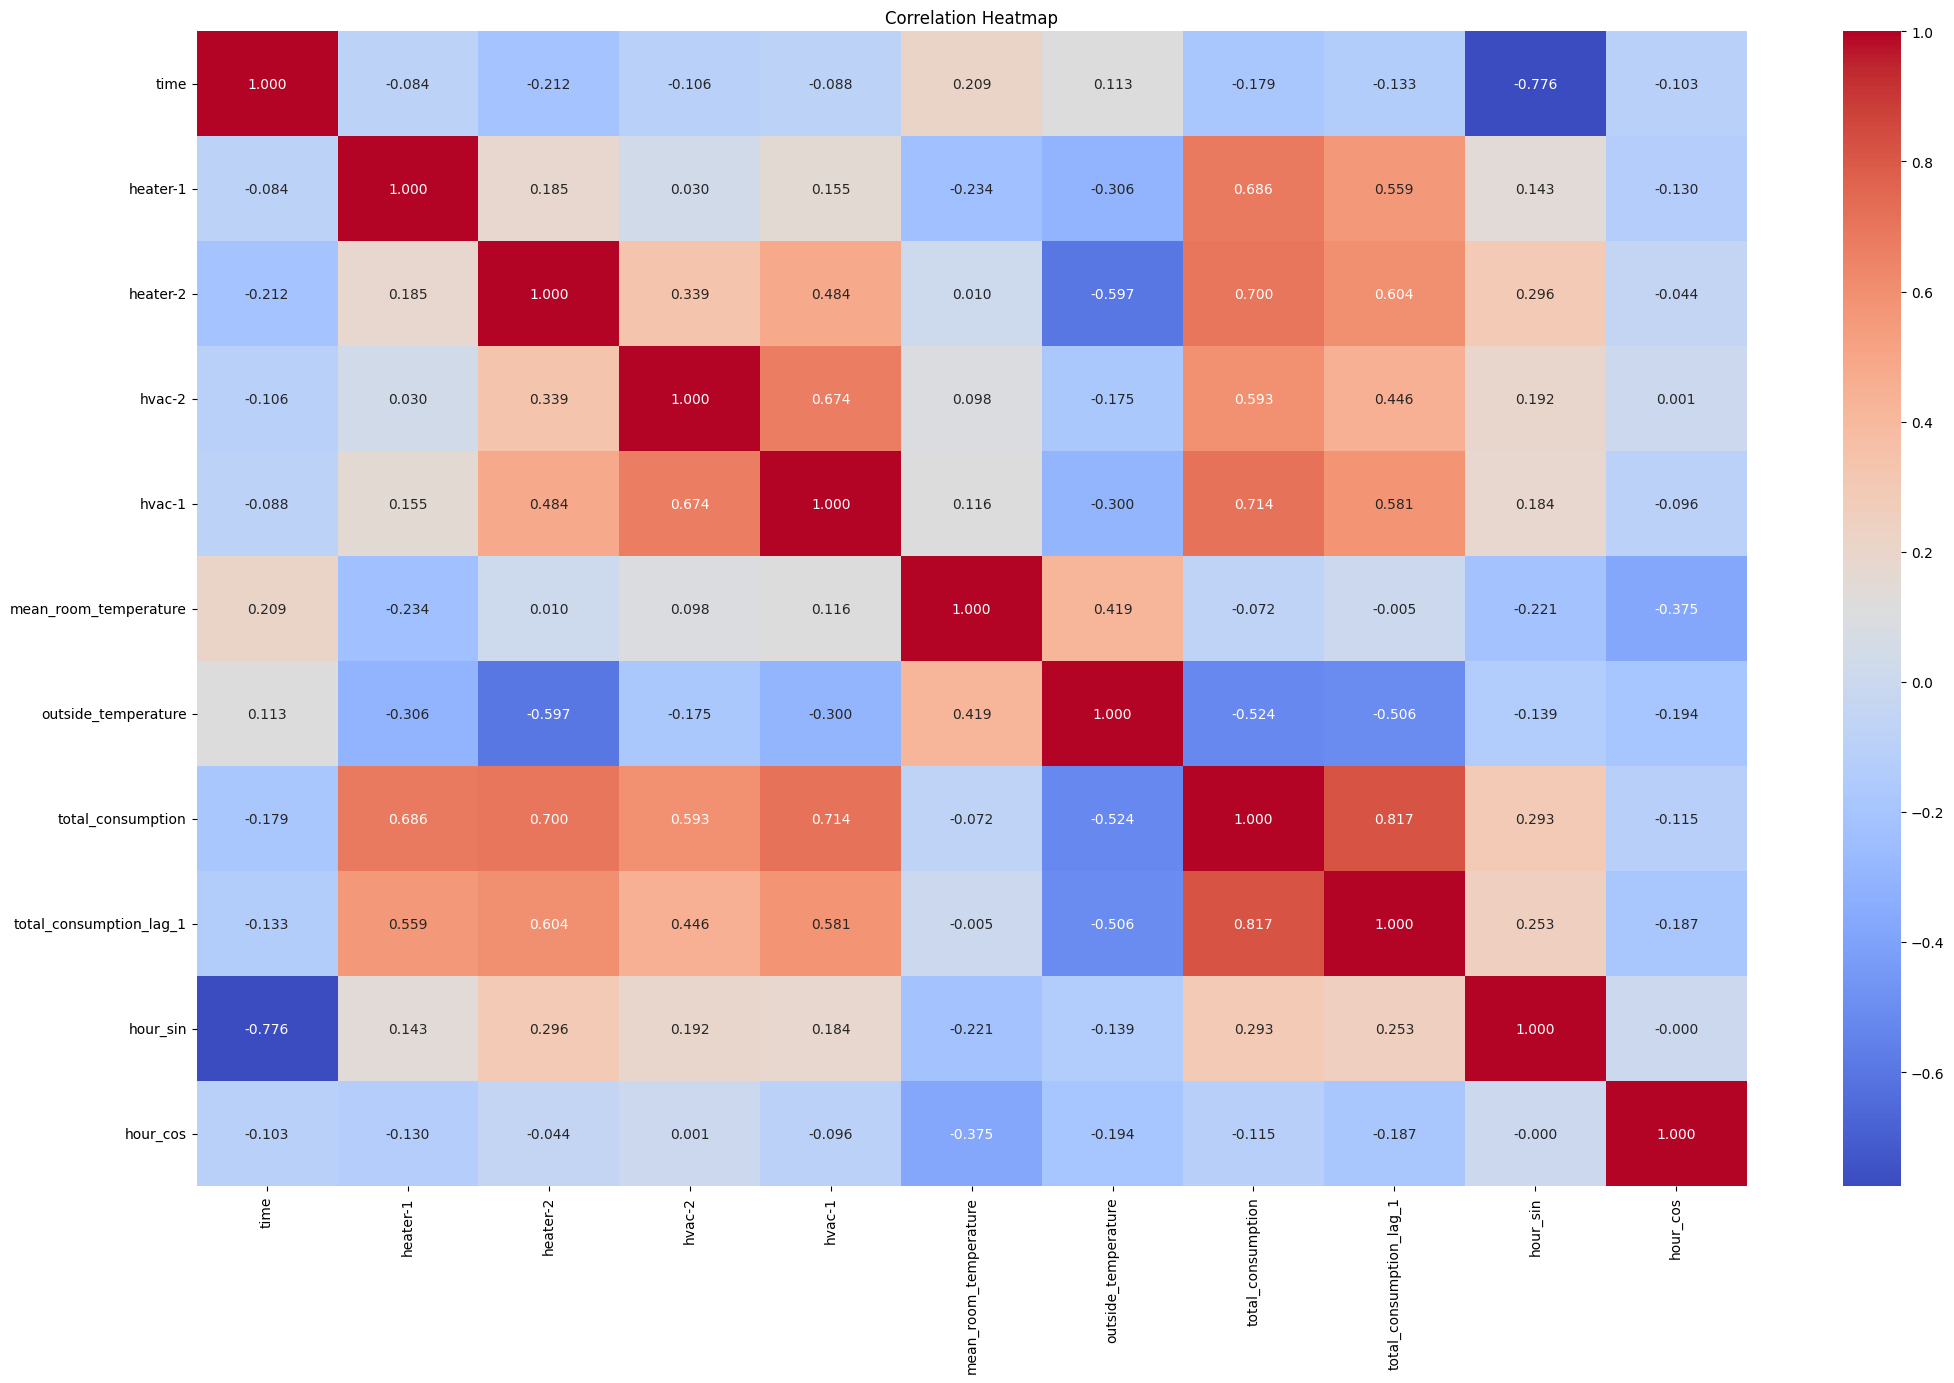

In [ ]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()
# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
import itertools
def select_features(X, feature_names):
    """Selects only the specified feature names from the dataset."""
    return X[feature_names]

def testing_with_pipeline(feature_sets, X_train, X_test, y_train, y_test):
    results = []
    for r in range(1, len(feature_sets) + 1):  # Test combinations of 1 group, 2 groups, ..., all groups
        for combination in itertools.combinations(feature_sets.keys(), r):
            # Combine selected feature groups into a single feature list
            selected_features = [feature for group in combination for feature in feature_sets[group]]
            
            # Train the pipeline
            pipe.fit(X_train, y_train)
            
            # Evaluate performance
            y_pred = pipe.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            
            # Store results
            results.append({"combination": combination, "mae": mae})
            print(f"Tested combination: {combination}, MAE: {mae}")

          
    best_result = min(results, key=lambda x: x["mae"])
    print(" ")
    print(" ")
    print("Best Feature Combination: ", best_result["combination"])
    print("MAE: ", best_result["mae"])
    return results

testing_with_pipeline(feature_sets, X_train, X_test, y_train, y_test)

print("")

Tested combination: ('time_features',), MAE: 2.9253091034189826
Tested combination: ('hvac_heater_features',), MAE: 2.985533031963289
Tested combination: ('temperature_features',), MAE: 2.914002911279425


KeyboardInterrupt: 

In [ ]:
finalData = edit_data(ogTestData.copy())
finalPipe = Pipeline(steps)

finalPipe.fit(trainingDataX[features], trainingDataY)
finalPred = finalPipe.predict(finalData[features])

finalPred = pd.DataFrame(finalPred, columns=["target"])
finalPred.index = ogTestData['ID']
finalPred.count = None
finalPred.to_csv("submission.csv")

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9160\176391563.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour_sin"] = np.sin(df["time"] / 24 * 2 * np.pi)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9160\176391563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour_cos"] = np.cos(df["time"] / 24 * 2 * np.pi)


In [22]:
trainData = time_transformer(trainData)
allFeatures += ["hour_sin", "hour_cos"]

trainData[allFeatures].to_csv("all_features.csv", index=False)